In [135]:
import numpy as np
import pandas as pd
import os, re, time, math, tqdm, itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import seaborn as sns
# sns.set_style("whitegrid")

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_selection import RFECV, SequentialFeatureSelector

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn import metrics


from keras.layers import Dense, Dropout, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.models import Model
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.layers import SpatialDropout1D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import LSTM

from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adam


import warnings
warnings.filterwarnings("ignore")

In [136]:
# Reading clean cicids2017 csv file
df = pd.read_csv('data/Cleaned_Dataset_CICIDS2017.csv')

In [137]:
print("Columns in dataframe:\n")
columns = [col for col in df.columns]
print(columns)

Columns in dataframe:

['DestinationPort', 'FlowDuration', 'TotalFwdPackets', 'TotalBackwardPackets', 'TotalLengthofFwdPackets', 'TotalLengthofBwdPackets', 'FwdPacketLengthMax', 'FwdPacketLengthMin', 'FwdPacketLengthMean', 'FwdPacketLengthStd', 'BwdPacketLengthMax', 'BwdPacketLengthMin', 'BwdPacketLengthMean', 'BwdPacketLengthStd', 'FlowBytes/s', 'FlowPackets/s', 'FlowIATMean', 'FlowIATStd', 'FlowIATMax', 'FlowIATMin', 'FwdIATTotal', 'FwdIATMean', 'FwdIATStd', 'FwdIATMax', 'FwdIATMin', 'BwdIATTotal', 'BwdIATMean', 'BwdIATStd', 'BwdIATMax', 'BwdIATMin', 'FwdPSHFlags', 'BwdPSHFlags', 'FwdURGFlags', 'BwdURGFlags', 'FwdHeaderLength', 'BwdHeaderLength', 'FwdPackets/s', 'BwdPackets/s', 'MinPacketLength', 'MaxPacketLength', 'PacketLengthMean', 'PacketLengthStd', 'PacketLengthVariance', 'FINFlagCount', 'SYNFlagCount', 'RSTFlagCount', 'PSHFlagCount', 'ACKFlagCount', 'URGFlagCount', 'CWEFlagCount', 'ECEFlagCount', 'Down/UpRatio', 'AveragePacketSize', 'AvgFwdSegmentSize', 'AvgBwdSegmentSize', 'Fw

In [138]:
print("Total no. of columns: {}".format(len(columns)))

Total no. of columns: 79


In [139]:
# Class of attacks
print(df['Label'].unique())

['BENIGN' 'FTPPatator' 'SSHPatator' 'DoS_slowloris' 'DoS_Slowhttptest'
 'DoS_Hulk' 'DoS_GoldenEye' 'Heartbleed' 'Web_Attack_Brute_Force'
 'Web_Attack_XSS' 'Web_Attack_Sql_Injection' 'Infiltration' 'Bot'
 'PortScan' 'DDoS']


In [140]:
# Total number of samples in each class of attacks
print(df['Label'].value_counts())

Label
BENIGN                      2035505
DoS_Hulk                     171509
DDoS                         128005
PortScan                      57305
DoS_GoldenEye                 10279
FTPPatator                     5480
DoS_slowloris                  5289
DoS_Slowhttptest               5176
SSHPatator                     3071
Bot                            1943
Web_Attack_Brute_Force         1445
Web_Attack_XSS                  652
Infiltration                     36
Web_Attack_Sql_Injection         21
Heartbleed                       11
Name: count, dtype: int64


In [141]:
labels = df['Label'].unique()
values = df['Label'].value_counts().tolist()
values_percentage =[ value / len(df['Label']) for value in values]
data = {'Family': labels,
       'Total_Samples': values,
       'Sample_percentate':values_percentage}
df_percentage = pd.DataFrame(data)
print(df_percentage)

                      Family  Total_Samples  Sample_percentate
0                     BENIGN        2035505           0.839132
1                 FTPPatator         171509           0.070704
2                 SSHPatator         128005           0.052770
3              DoS_slowloris          57305           0.023624
4           DoS_Slowhttptest          10279           0.004237
5                   DoS_Hulk           5480           0.002259
6              DoS_GoldenEye           5289           0.002180
7                 Heartbleed           5176           0.002134
8     Web_Attack_Brute_Force           3071           0.001266
9             Web_Attack_XSS           1943           0.000801
10  Web_Attack_Sql_Injection           1445           0.000596
11              Infiltration            652           0.000269
12                       Bot             36           0.000015
13                  PortScan             21           0.000009
14                      DDoS             11           0

# Bar chart representation for each class

In [142]:
def show_class_distribution(df: pd.DataFrame, title: str) -> None:
    plt.figure(figsize=(20,6), dpi=100)
    nums = df["Label"].value_counts().sort_index()
    ax = sns.barplot(x=nums.index, y=nums.values)
    ax.set(xlabel="Class", ylabel="Number of Samples", title=title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    # plt.savefig("packet_distribution")
    plt.grid(True)
    plt.show()

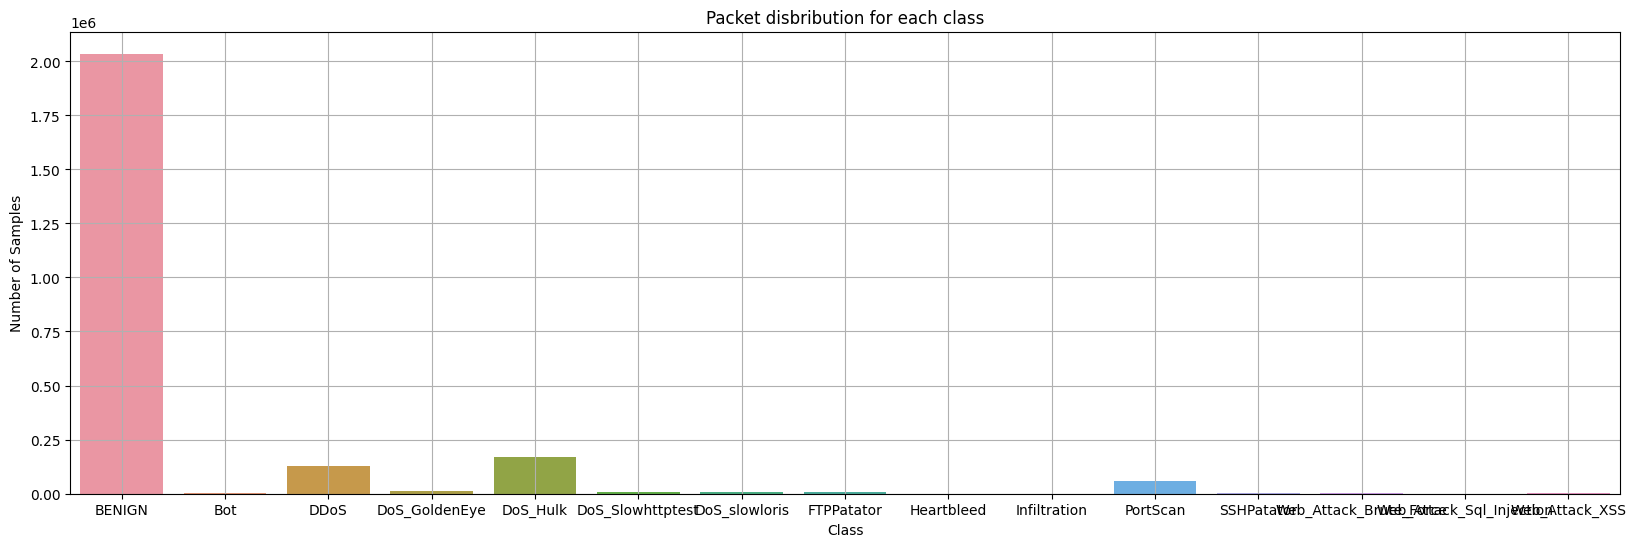

In [143]:
show_class_distribution(df, 'Packet disbribution for each class')

# Family Class grouping

In [144]:
#temporary dataframe
df1 = df
df_Benign = df1[df1['Label']=='BENIGN']
df_Malicious =  df1[df1['Label'] != 'BENIGN']
print(df_Benign.shape)
print(df_Benign['Label'].value_counts())


(2035505, 79)
Label
BENIGN    2035505
Name: count, dtype: int64


In [145]:
# sampling only 50% of Benign samples
df_Benign = df_Benign.sample(frac=0.2)
print("After 50% sample of Benign class, shape of df_Benigh: ",df_Benign.shape)

#contatinating two dataframe
df1 = pd.concat([df_Benign, df_Malicious])
df1=df1.sample(frac=1).reset_index(drop=True)
df1

After 50% sample of Benign class, shape of df_Benigh:  (407101, 79)


,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,443.0,98654.0,19.0,25.0,1245.0,43949.0,562.0,0.0,65.526316,167.600507,...,20.0,0.0000,0.0000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,BENIGN
1,53.0,192.0,2.0,2.0,90.0,240.0,45.0,45.0,45.000000,0.000000,...,32.0,0.0000,0.0000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,BENIGN
2,80.0,84869152.0,6.0,6.0,389.0,11595.0,371.0,0.0,64.833333,150.019221,...,20.0,10995.0000,0.0000,10995.0,10995.0,8.470000e+07,0.000000e+00,84700000.0,84700000.0,DoS_Hulk
3,53.0,89980.0,2.0,2.0,70.0,190.0,35.0,35.0,35.000000,0.000000,...,32.0,0.0000,0.0000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,BENIGN
4,53.0,136448.0,2.0,2.0,90.0,326.0,45.0,45.0,45.000000,0.000000,...,20.0,0.0000,0.0000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797318,443.0,63032706.0,15.0,13.0,777.0,3815.0,374.0,0.0,51.800000,107.044850,...,20.0,476480.3333,898874.8879,2311301.0,109358.0,9.999458e+06,6.073509e+04,10100000.0,9899370.0,BENIGN
797319,53.0,23514.0,1.0,1.0,47.0,128.0,47.0,47.0,47.000000,0.000000,...,20.0,0.0000,0.0000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,BENIGN
797320,80.0,100964848.0,8.0,5.0,56.0,11601.0,20.0,0.0,7.000000,5.656854,...,20.0,8004.0000,0.0000,8004.0,8004.0,5.050000e+07,6.400000e+07,95700000.0,5254862.0,DDoS
797321,80.0,84667325.0,5.0,6.0,369.0,11595.0,357.0,0.0,73.800000,158.342035,...,20.0,11009.0000,0.0000,11009.0,11009.0,8.450000e+07,0.000000e+00,84500000.0,84500000.0,DoS_Hulk


In [146]:
DoS_Labels =  ['Dos_Hulk', 'DoS_GoldenEye', 'DoS_slowloris', 'DoS_Slowhttptest']
Web_Labels = ['Web_Attack_Brute_Force', 'Web_Attack_XSS', 'Web_Attack_Sql_Injection']


In [147]:
print("Before resmapling:\m")
df1['Label'].unique()

Before resmapling:\m


array(['BENIGN', 'DoS_Hulk', 'DDoS', 'PortScan', 'DoS_Slowhttptest',
       'FTPPatator', 'Web_Attack_Brute_Force', 'DoS_slowloris',
       'SSHPatator', 'DoS_GoldenEye', 'Bot', 'Web_Attack_XSS',
       'Infiltration', 'Heartbleed', 'Web_Attack_Sql_Injection'],
      dtype=object)

In [148]:
# df1.loc[df1['Label'] == "DoS_Hulk", "Label"] = 'DoS'


In [149]:
for i in DoS_Labels:
    df1.loc[df1['Label'] == i, "Label"] = 'DoS'
for i in Web_Labels:
    df1.loc[df1['Label'] == i, "Label"] = 'Web_Attack'

# Drop row having label equal to 'infiltration' and 'heartbleed' in dataframe
df1 = df1.drop(df1[df1['Label'] == 'Infiltration'].index)
df1 = df1.drop(df1[df1['Label'] == 'Heartbleed'].index)
    

In [150]:
print(df1['Label'].value_counts())

Label
BENIGN        407101
DoS_Hulk      171509
DDoS          128005
PortScan       57305
DoS            20744
FTPPatator      5480
SSHPatator      3071
Web_Attack      2118
Bot             1943
Name: count, dtype: int64


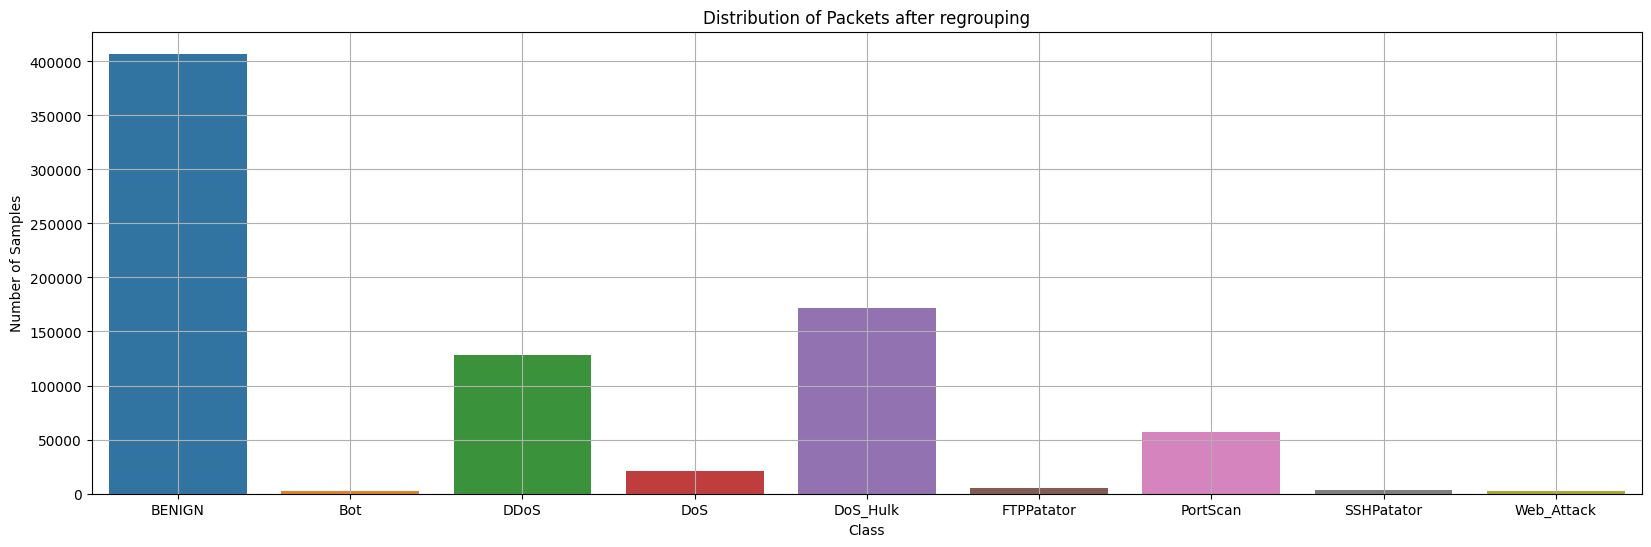

In [151]:
show_class_distribution(df1, "Distribution of Packets after regrouping")

# Feature Selection

In [152]:
# drop the constant columns (which varience is 0)
variances = df1.var(numeric_only=True)
constant_columns = variances[variances == 0].index
df1.drop(constant_columns, axis=1, inplace=True)
print(constant_columns)
print(df1.shape)

Index(['BwdPSHFlags', 'BwdURGFlags', 'FwdAvgBytes/Bulk', 'FwdAvgPackets/Bulk',
       'FwdAvgBulkRate', 'BwdAvgBytes/Bulk', 'BwdAvgPackets/Bulk',
       'BwdAvgBulkRate'],
      dtype='object')
(797276, 71)


In [153]:
print(df1.columns)

Index(['DestinationPort', 'FlowDuration', 'TotalFwdPackets',
       'TotalBackwardPackets', 'TotalLengthofFwdPackets',
       'TotalLengthofBwdPackets', 'FwdPacketLengthMax', 'FwdPacketLengthMin',
       'FwdPacketLengthMean', 'FwdPacketLengthStd', 'BwdPacketLengthMax',
       'BwdPacketLengthMin', 'BwdPacketLengthMean', 'BwdPacketLengthStd',
       'FlowBytes/s', 'FlowPackets/s', 'FlowIATMean', 'FlowIATStd',
       'FlowIATMax', 'FlowIATMin', 'FwdIATTotal', 'FwdIATMean', 'FwdIATStd',
       'FwdIATMax', 'FwdIATMin', 'BwdIATTotal', 'BwdIATMean', 'BwdIATStd',
       'BwdIATMax', 'BwdIATMin', 'FwdPSHFlags', 'FwdURGFlags',
       'FwdHeaderLength', 'BwdHeaderLength', 'FwdPackets/s', 'BwdPackets/s',
       'MinPacketLength', 'MaxPacketLength', 'PacketLengthMean',
       'PacketLengthStd', 'PacketLengthVariance', 'FINFlagCount',
       'SYNFlagCount', 'RSTFlagCount', 'PSHFlagCount', 'ACKFlagCount',
       'URGFlagCount', 'CWEFlagCount', 'ECEFlagCount', 'Down/UpRatio',
       'AveragePacketS

# Checking Corelation of columns of dataframe

In [154]:
# Note: The corr() method ignores "not numeric" columns.

corr = df1.corr(method ='pearson', numeric_only=True)
corr

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
DestinationPort,1.000000,-0.212768,-0.003803,-0.003324,0.024779,-0.002619,0.084482,-0.005140,0.135530,0.107261,...,-0.002698,0.000669,-0.043934,-0.033963,-0.050998,-0.035457,-0.189829,-0.031199,-0.190218,-0.185737
FlowDuration,-0.212768,1.000000,0.013531,0.011944,0.081062,0.009808,0.233867,-0.136578,0.106262,0.219577,...,0.008961,0.000597,0.163227,0.157683,0.213957,0.119978,0.882318,0.254500,0.899167,0.847577
TotalFwdPackets,-0.003803,0.013531,1.000000,0.998543,0.660848,0.994181,0.009961,-0.002525,0.000625,0.001871,...,0.906008,-0.000571,0.069363,0.007951,0.054475,0.073092,0.000970,0.000729,0.001081,0.000832
TotalBackwardPackets,-0.003324,0.011944,0.998543,1.000000,0.654224,0.988748,0.009710,-0.002014,0.000325,0.001507,...,0.896613,0.000021,0.068173,0.005886,0.052382,0.072848,0.000141,-0.000035,0.000130,0.000120
TotalLengthofFwdPackets,0.024779,0.081062,0.660848,0.654224,1.000000,0.656849,0.391155,-0.000389,0.378537,0.325949,...,0.720710,-0.005213,0.151899,0.149127,0.193004,0.106501,0.018704,0.021736,0.022147,0.015128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ActiveMin,-0.035457,0.119978,0.073092,0.072848,0.106501,0.069207,0.049925,-0.028421,0.036570,0.043572,...,0.079021,-0.006236,0.916887,0.015753,0.656995,1.000000,0.083830,0.047886,0.093275,0.075188
IdleMean,-0.189829,0.882318,0.000970,0.000141,0.018704,0.000473,0.159863,-0.118934,0.077406,0.174847,...,-0.000727,0.000658,0.073875,-0.010037,0.041113,0.083830,1.000000,0.098436,0.989533,0.989758
IdleStd,-0.031199,0.254500,0.000729,-0.000035,0.021736,0.000025,0.068076,-0.037607,0.070516,0.076791,...,0.000760,-0.000032,0.079508,0.086580,0.079886,0.047886,0.098436,1.000000,0.238651,-0.044381
IdleMax,-0.190218,0.899167,0.001081,0.000130,0.022147,0.000457,0.165472,-0.121692,0.086269,0.181421,...,-0.000580,0.000642,0.094017,0.018085,0.063684,0.093275,0.989533,0.238651,1.000000,0.959149


In [155]:
correlated_col = set()
is_correlated = [True] * len(corr.columns)
threshold = 0.90
for i in range (len(corr.columns)):
    if(is_correlated[i]):
        for j in range(i):
          if (corr.iloc[i, j] >= threshold) and (is_correlated[j]):
            colname = corr.columns[j]
            is_correlated[j]=False
            correlated_col.add(colname)

print(correlated_col)
print(len(correlated_col))

{'ActiveMean', 'PacketLengthStd', 'IdleMean', 'FlowPackets/s', 'FwdPSHFlags', 'FwdURGFlags', 'FlowIATMean', 'SubflowBwdPackets', 'FwdIATMax', 'FlowIATMax', 'FwdIATStd', 'FwdPacketLengthMean', 'FlowDuration', 'AveragePacketSize', 'PacketLengthMean', 'TotalBackwardPackets', 'TotalLengthofBwdPackets', 'SubflowFwdPackets', 'TotalLengthofFwdPackets', 'FlowIATStd', 'RSTFlagCount', 'FwdPacketLengthMax', 'FwdHeaderLength', 'SubflowBwdBytes', 'MaxPacketLength', 'IdleMax', 'TotalFwdPackets', 'BwdPacketLengthMax', 'BwdIATStd', 'BwdPacketLengthStd', 'BwdPacketLengthMean', 'FwdIATTotal'}
32


In [156]:
# dropping corelated coluns
df1.drop(correlated_col, axis=1, inplace=True)
df1.shape

(797276, 39)

In [157]:
df1['Label'].value_counts()

Label
BENIGN        407101
DoS_Hulk      171509
DDoS          128005
PortScan       57305
DoS            20744
FTPPatator      5480
SSHPatator      3071
Web_Attack      2118
Bot             1943
Name: count, dtype: int64

# Saving dataframe after regrouping of class


In [158]:
# df1.to_csv('data/cicids2017_regrouping_class_featureselection.csv', index=False)

In [159]:
# encode a labels
label_encoder = LabelEncoder()
df1['Label'] = label_encoder.fit_transform(df1['Label'].values.ravel())
df1['Label'].unique()

array([0, 4, 2, 6, 3, 5, 8, 7, 1])

In [160]:
df1.head(10)

,DestinationPort,FwdPacketLengthMin,FwdPacketLengthStd,BwdPacketLengthMin,FlowBytes/s,FlowIATMin,FwdIATMean,FwdIATMin,BwdIATTotal,BwdIATMean,...,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveStd,ActiveMax,ActiveMin,IdleStd,IdleMin,Label
0,443.0,0.0,167.600507,0.0,4.581061e+05,18.0,5.480778e+03,48.0,75480.0,3145.0,...,8192.0,62.0,18.0,20.0,0.0,0.0,0.0,0.0,0.0,0
1,53.0,45.0,0.000000,120.0,1.718750e+06,3.0,3.000000e+00,3.0,3.0,3.0,...,-1.0,-1.0,1.0,32.0,0.0,0.0,0.0,0.0,0.0,0
2,80.0,0.0,150.019221,0.0,1.412056e+02,72.0,1.690000e+07,191.0,84900000.0,17000000.0,...,0.0,235.0,3.0,20.0,0.0,10995.0,10995.0,0.0,84700000.0,4
3,53.0,35.0,0.000000,95.0,2.889531e+03,3.0,4.000000e+00,4.0,3.0,3.0,...,-1.0,-1.0,1.0,32.0,0.0,0.0,0.0,0.0,0.0,0
4,53.0,45.0,0.000000,163.0,3.048780e+03,4.0,4.000000e+00,4.0,49.0,49.0,...,-1.0,-1.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0
5,53.0,42.0,0.000000,105.0,4.767310e+03,30835.0,0.000000e+00,0.0,0.0,0.0,...,-1.0,-1.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0
6,80.0,0.0,10.263203,0.0,9.405969e+04,16.0,5.096500e+03,606.0,123569.0,24713.8,...,8192.0,229.0,2.0,20.0,0.0,0.0,0.0,0.0,0.0,2
7,443.0,0.0,0.000000,0.0,0.000000e+00,19.0,4.110000e+02,19.0,0.0,0.0,...,282.0,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0
8,80.0,6.0,0.000000,0.0,6.097425e+00,268.0,1.312029e+06,268.0,0.0,0.0,...,256.0,-1.0,3.0,20.0,0.0,0.0,0.0,0.0,0.0,2
9,53.0,49.0,0.000000,114.0,7.015883e+03,23233.0,0.000000e+00,0.0,0.0,0.0,...,-1.0,-1.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0


In [161]:
X = df1.drop('Label', axis=1).values
y = df1['Label'].values
X.shape, y.shape

((797276, 38), (797276,))

In [162]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled.shape

(797276, 38)

In [163]:
from keras.utils import to_categorical
y_categorical = to_categorical(y)
y_categorical.shape

(797276, 9)

# Test and Train


In [192]:
from sklearn.model_selection import train_test_split   
X_train, X_test, y_train, y_test=train_test_split(X_scaled, y_categorical, test_size=0.2, random_state=47)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((637820, 38), (159456, 38), (637820, 9), (159456, 9))

# Reshapping train and test 

In [193]:
X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1 )

print("After Reshaping:")
X_train.shape, X_test.shape

After Reshaping:


((637820, 38, 1), (159456, 38, 1))

# Parameters

In [194]:
epochs = 10
batch_size = 64
validation_split = 0.2
input_shape = (X_train.shape[1],1)
num_classes=len(df1['Label'].unique())
print(input_shape)
print(num_classes)

(38, 1)
9


In [128]:
# import os
# logDir = "logCNNnMultiClass"
# if not os.path.exists(logDir):
#     os.mkdir(logDir)

# Define a CNN Model

In [195]:
def cnnLSTM_MultiClass():
    model = Sequential()
    model.add(Conv1D(filters=16, kernel_size = 3, activation='relu', input_shape=(38, 1)))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(0.25))

    model.add(Conv1D(filters=32, kernel_size = 3, activation='relu', input_shape=(38, 1)))
    model.add(MaxPooling1D(pool_size=(2)))

    model.add(Conv1D(filters=64, kernel_size = 3, activation='relu', input_shape=(38, 1)))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(0.25))


    model.add(LSTM(64))
    model.add(Dropout(0.25))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

    return model


In [196]:
# param_grid = {
#     "learning_rate": [0.1, 0.01, 0.001],
#     "dropout_rate": [0.2, 0.3, 0.4],
#     "batch_size": [32, 64, 128],
# #     "epochs": [10, 20, 30]
# }

In [197]:
# model = KerasClassifier(build_fn=cnnLSTM_MultiClass)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
# grid_result = grid.fit(X_train, 
#                        y_train,
#                        epochs=3
#                        )

In [198]:
# print("Best hyperparameters: ", grid_result.best_params_)
# print("Best validation accuracy: ", grid_result.best_score_)

In [199]:
model = cnnLSTM_MultiClass()
model.summary()

Model: "sequential_520"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1560 (Conv1D)        (None, 36, 16)            64        
                                                                 
 max_pooling1d_1560 (MaxPool  (None, 18, 16)           0         
 ing1D)                                                          
                                                                 
 dropout_1046 (Dropout)      (None, 18, 16)            0         
                                                                 
 conv1d_1561 (Conv1D)        (None, 16, 32)            1568      
                                                                 
 max_pooling1d_1561 (MaxPool  (None, 8, 32)            0         
 ing1D)                                                          
                                                                 
 conv1d_1562 (Conv1D)        (None, 6, 64)          

# Training Model

In [200]:

history1 = model.fit(X_train,
                     y_train,
                     epochs = epochs,
                     batch_size = batch_size,
                     validation_split = 0.2
                    #  validation_data = (X_val, y_val),
#                      callbacks=[my_callbacks]
                     )
model.save("cnnmulticlass_cicids2017.h5")

Epoch 1/10
7973/7973 [==============================] - 133s 15ms/step - loss: 0.1854 - accuracy: 0.9450 - val_loss: 0.0662 - val_accuracy: 0.9822
Epoch 2/10
7973/7973 [==============================] - 119s 15ms/step - loss: 0.0814 - accuracy: 0.9775 - val_loss: 0.0409 - val_accuracy: 0.9874
Epoch 3/10
7973/7973 [==============================] - 120s 15ms/step - loss: 0.0689 - accuracy: 0.9816 - val_loss: 0.0405 - val_accuracy: 0.9888
Epoch 4/10
7973/7973 [==============================] - 121s 15ms/step - loss: 0.0636 - accuracy: 0.9828 - val_loss: 0.0343 - val_accuracy: 0.9894
Epoch 5/10
7973/7973 [==============================] - 116s 15ms/step - loss: 0.0563 - accuracy: 0.9845 - val_loss: 0.0356 - val_accuracy: 0.9897
Epoch 6/10
7973/7973 [==============================] - 116s 14ms/step - loss: 0.0541 - accuracy: 0.9855 - val_loss: 0.0322 - val_accuracy: 0.9911
Epoch 7/10
7973/7973 [==============================] - 118s 15ms/step - loss: 0.0552 - accuracy: 0.9858 - val_loss: 0

In [201]:
# check history
history = history1.history
print(history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [215]:
def plot_train_validation_graph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(loss))

    plt.figure(figsize=(8, 6), dpi=100)
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='g')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='r')
    plt.xlabel('Epoches')
    plt.ylabel('Score')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epoches')
    plt.ylabel('Score')
    plt.title('Training and Validation Loss')
    plt.savefig("Train_vs_Validation_CNNulticlass.png")
    plt.tight_layout(pad=1.0)
    plt.grid(True)
    plt.show()

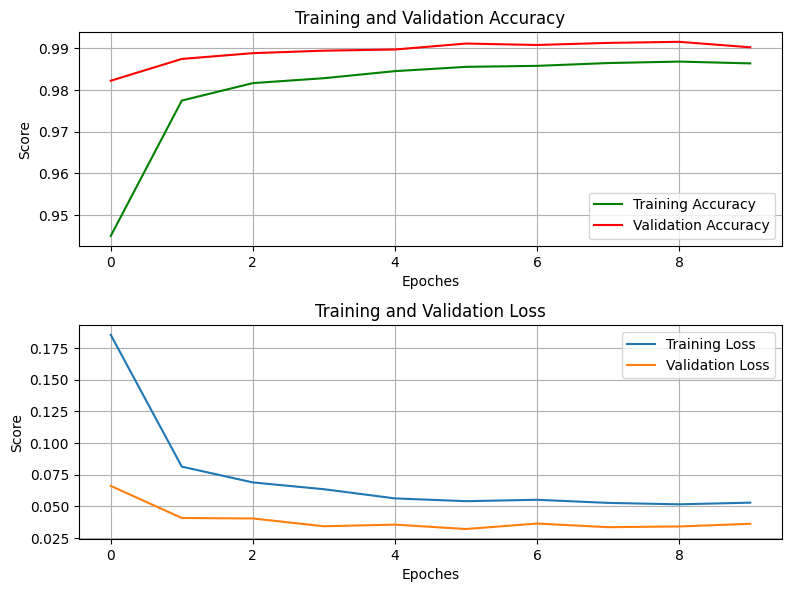

In [216]:
plot_train_validation_graph(history1)

# Prediction Results

In [206]:
#  check the model performance on test data
scores = model.evaluate(X_test, y_test)
print("Test %s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


4983/4983 [==============================] - 38s 8ms/step - loss: 0.0373 - accuracy: 0.9900
Test accuracy: 99.00%
Test loss: 0.03726214915513992
Test accuracy: 0.9900035262107849


# Confusion Matrix

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

4983/4983 [==============================] - 25s 5ms/step


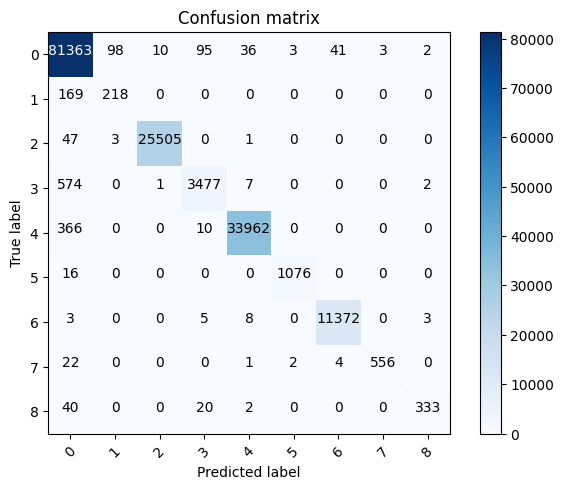

In [210]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(num_classes))

In [211]:
precision = precision_score(Y_true, Y_pred_classes, average='weighted')
F1_score = f1_score(Y_true, Y_pred_classes, average='weighted')
Recall = recall_score(Y_true, Y_pred_classes, average='weighted')

print("Precision:", precision)
print("F1-Score: ", F1_score)
print("Recall: ", Recall)

Precision: 0.9898439887858601
F1-Score:  0.9897919647883627
Recall:  0.990003511940598


# Classification Report

In [212]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     81651
           1       0.68      0.56      0.62       387
           2       1.00      1.00      1.00     25556
           3       0.96      0.86      0.91      4061
           4       1.00      0.99      0.99     34338
           5       1.00      0.99      0.99      1092
           6       1.00      1.00      1.00     11391
           7       0.99      0.95      0.97       585
           8       0.98      0.84      0.91       395

    accuracy                           0.99    159456
   macro avg       0.96      0.91      0.93    159456
weighted avg       0.99      0.99      0.99    159456

